In [1]:
from rdkit.Chem import rdChemReactions as Reactions
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import Image as ImageD, display, clear_output
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import io

In [2]:
def clear_atom_mapping(rxn):
    for reactant in rxn.GetReactants():
        for atom in reactant.GetAtoms():
            atom.SetAtomMapNum(0)
    for product in rxn.GetProducts():
        for atom in product.GetAtoms():
            atom.SetAtomMapNum(0)
    return rxn

def offset_bond_indices_by_molecule(rxn):
    offset = 0
    for mol in list(rxn.GetReactants())+list(rxn.GetProducts()):
        for bond in mol.GetBonds():
            bond.SetBondTypeAsDouble(offset + bond.GetIdx())
        offset += mol.GetNumBonds()


In [3]:
multiple = {'[c:1]1([N:16]2[CH2:15][CH2:14][C@@H:13]([OH:12])[CH2:17]2)[c:2]([O:3][CH3:4])[cH:5][c:6]([N+:7](=[O:8])[O-:9])[cH:10][cH:11]1': 
                ['Cl[c:1]1[c:2]([O:3][CH3:4])[cH:5][c:6]([N+:7](=[O:8])[O-:9])[cH:10][cH:11]1.[OH:12][CH:13]1[CH2:14][CH2:15][NH:16][CH2:17]1', 
                 'Cl[c:1]1[c:2]([O:3][CH3:4])[cH:5][c:6]([N+:7](=[O:8])[O-:9])[cH:10][cH:11]1.[OH:12][C@@H:13]1[CH2:14][CH2:15][NH:16][CH2:17]1'], 
            '[c:1]1([N:8]([CH3:7])[CH2:9][CH2:10][NH:11][CH3:12])[cH:2][cH:3][cH:4][cH:5][n:6]1': 
                ['Cl[c:1]1[cH:2][cH:3][cH:4][cH:5][n:6]1.[CH3:7][NH:8][CH2:9][CH2:10][NH:11][CH3:12]', 
                 'F[c:1]1[cH:2][cH:3][cH:4][cH:5][n:6]1.[CH3:7][NH:8][CH2:9][CH2:10][NH:11][CH3:12]'], 
            '[CH2:1]([OH:2])[c:3]1[cH:4][cH:5][cH:6][cH:7][c:8]1[O:9][c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1': 
            ['CO[C:1](=[O:2])[c:3]1[cH:4][cH:5][cH:6][cH:7][c:8]1[O:9][c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1', 
             'O=[C:1]([OH:2])[c:3]1[cH:4][cH:5][cH:6][cH:7][c:8]1[O:9][c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1'], 
            '[C:1](=[O:2])([CH2:3][Br:4])[NH:13][c:12]1[c:6]([CH3:5])[cH:7][cH:8][cH:9][c:10]1[CH3:11]': 
            ['O[C:1](=[O:2])[CH2:3][Br:4].[CH3:5][c:6]1[cH:7][cH:8][cH:9][c:10]([CH3:11])[c:12]1[NH2:13]', 
             'Br[C:1](=[O:2])[CH2:3][Br:4].[CH3:5][c:6]1[cH:7][cH:8][cH:9][c:10]([CH3:11])[c:12]1[NH2:13]'], 
            '[CH:1]([CH3:2])([CH3:3])[O:13][c:12]1[c:7]([N+:5](=[O:4])[O-:6])[cH:8][cH:9][cH:10][cH:11]1': 
            ['O[CH:1]([CH3:2])[CH3:3].[O:4]=[N+:5]([O-:6])[c:7]1[cH:8][cH:9][cH:10][cH:11][c:12]1[OH:13]', 
             'Br[CH:1]([CH3:2])[CH3:3].[O:4]=[N+:5]([O-:6])[c:7]1[cH:8][cH:9][cH:10][cH:11][c:12]1[OH:13]'], 
             '[CH3:1][CH2:2][O:3][C:4](=[O:5])[CH2:6][CH2:7][c:8]1[cH:9][cH:10][c:11]([C:12]#[N:13])[cH:14][cH:15]1': 
             ['[CH3:1][CH2:2][O:3][C:4](=[O:5])/[CH:6]=[CH:7]/[c:8]1[cH:9][cH:10][c:11]([C:12]#[N:13])[cH:14][cH:15]1', 
              '[CH3:1][CH2:2][O:3][C:4](=[O:5])[CH:6]=[CH:7][c:8]1[cH:9][cH:10][c:11]([C:12]#[N:13])[cH:14][cH:15]1'], 
              '[OH:1][C:2](=[O:3])[CH2:4][c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1': 
              ['c1ccc(C[O:1][C:2](=[O:3])[CH2:4][c:5]2[cH:6][cH:7][cH:8][cH:9][cH:10]2)cc1', 
               'C[O:1][C:2](=[O:3])[CH2:4][c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1'], 
               '[CH2:1]([C:2]([O:3][CH2:4][CH3:5])=[O:6])[N:17]1[CH2:16][CH2:15][c:13]2[c:12]([cH:11][cH:10][c:9]([O:8][CH3:7])[cH:14]2)[C:18]1=[O:19]': 
               ['Cl[CH2:1][C:2]([O:3][CH2:4][CH3:5])=[O:6].[CH3:7][O:8][c:9]1[cH:10][cH:11][c:12]2[c:13]([cH:14]1)[CH2:15][CH2:16][NH:17][C:18]2=[O:19]', 
                'Br[CH2:1][C:2]([O:3][CH2:4][CH3:5])=[O:6].[CH3:7][O:8][c:9]1[cH:10][cH:11][c:12]2[c:13]([cH:14]1)[CH2:15][CH2:16][NH:17][C:18]2=[O:19]'], 
                '[CH2:1]([CH3:2])[O:10][C:8]([c:7]1[cH:6][cH:5][c:4]([NH2:3])[n:12][cH:11]1)=[O:9]': 
                ['O[CH2:1][CH3:2].[NH2:3][c:4]1[cH:5][cH:6][c:7]([C:8](=[O:9])[OH:10])[cH:11][n:12]1', 'I[CH2:1][CH3:2].[NH2:3][c:4]1[cH:5][cH:6][c:7]([C:8](=[O:9])[OH:10])[cH:11][n:12]1'], 
                '[C:1](=[O:2])([c:3]1[cH:4][cH:5][c:6]([Cl:7])[cH:8][cH:9]1)[NH:10][CH2:11][CH2:12][N:13]1[CH2:14][CH2:15][O:16][CH2:17][CH2:18]1': 
                ['O[C:1](=[O:2])[c:3]1[cH:4][cH:5][c:6]([Cl:7])[cH:8][cH:9]1.[NH2:10][CH2:11][CH2:12][N:13]1[CH2:14][CH2:15][O:16][CH2:17][CH2:18]1', 
                 'Cl[C:1](=[O:2])[c:3]1[cH:4][cH:5][c:6]([Cl:7])[cH:8][cH:9]1.[NH2:10][CH2:11][CH2:12][N:13]1[CH2:14][CH2:15][O:16][CH2:17][CH2:18]1'], 
            '[NH2:1][CH2:2][CH2:3][c:4]1[cH:5][cH:6][c:7]([Cl:8])[c:9]([C:10](=[O:11])[NH:12][CH2:13][C:14]23[CH2:15][CH:16]4[CH2:17][CH:18]([CH2:19][CH:20]([CH2:21]4)[CH2:22]2)[CH2:23]3)[cH:24]1': 
                 ['[N:1]#[C:2][CH2:3][c:4]1[cH:5][cH:6][c:7]([Cl:8])[c:9]([C:10](=[O:11])[NH:12][CH2:13][C:14]23[CH2:15][CH:16]4[CH2:17][CH:18]([CH2:19][CH:20]([CH2:21]4)[CH2:22]2)[CH2:23]3)[cH:24]1', 
                  'CC(C)(C)OC(=O)[NH:1][CH2:2][CH2:3][c:4]1[cH:5][cH:6][c:7]([Cl:8])[c:9]([C:10](=[O:11])[NH:12][CH2:13][C:14]23[CH2:15][CH:16]4[CH2:17][CH:18]([CH2:19][CH:20]([CH2:21]4)[CH2:22]2)[CH2:23]3)[cH:24]1'], '[OH:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][c:7]([O:8][CH2:9][c:10]2[cH:11][cH:12][cH:13][cH:14][cH:15]2)[cH:16][cH:17]1': ['C[O:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][c:7]([O:8][CH2:9][c:10]2[cH:11][cH:12][cH:13][cH:14][cH:15]2)[cH:16][cH:17]1', 'CC[O:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][c:7]([O:8][CH2:9][c:10]2[cH:11][cH:12][cH:13][cH:14][cH:15]2)[cH:16][cH:17]1'], '[CH2:1]([c:2]1[cH:3][cH:4][c:5]([C:6]#[N:7])[cH:8][cH:9]1)[NH:11][CH3:10]': ['O=[CH:1][c:2]1[cH:3][cH:4][c:5]([C:6]#[N:7])[cH:8][cH:9]1.[CH3:10][NH2:11]', 'Br[CH2:1][c:2]1[cH:3][cH:4][c:5]([C:6]#[N:7])[cH:8][cH:9]1.[CH3:10][NH2:11]'], '[C:1]([c:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1)([c:8]1[cH:9][cH:10][cH:11][cH:12][cH:13]1)([c:14]1[cH:15][cH:16][cH:17][cH:18][cH:19]1)[n:22]1[cH:21][cH:20][n:24][cH:23]1': ['O[C:1]([c:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1)([c:8]1[cH:9][cH:10][cH:11][cH:12][cH:13]1)[c:14]1[cH:15][cH:16][cH:17][cH:18][cH:19]1.[cH:20]1[cH:21][nH:22][cH:23][n:24]1', 'Cl[C:1]([c:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1)([c:8]1[cH:9][cH:10][cH:11][cH:12][cH:13]1)[c:14]1[cH:15][cH:16][cH:17][cH:18][cH:19]1.[cH:20]1[cH:21][nH:22][cH:23][n:24]1'], '[OH:1][C:2](=[O:3])[CH2:4][CH2:5][CH2:6][N:7]1[CH2:8][CH2:9][O:10][CH2:11][CH2:12]1': ['CC[O:1][C:2](=[O:3])[CH2:4][CH2:5][CH2:6][N:7]1[CH2:8][CH2:9][O:10][CH2:11][CH2:12]1', 'C[O:1][C:2](=[O:3])[CH2:4][CH2:5][CH2:6][N:7]1[CH2:8][CH2:9][O:10][CH2:11][CH2:12]1'], '[OH:1][C:2](=[O:3])[CH:4]1[CH2:5][CH2:6][N:7]1[CH2:8][c:9]1[cH:10][cH:11][cH:12][cH:13][cH:14]1': ['C[O:1][C:2](=[O:3])[CH:4]1[CH2:5][CH2:6][N:7]1[CH2:8][c:9]1[cH:10][cH:11][cH:12][cH:13][cH:14]1', 'CC[O:1][C:2](=[O:3])[CH:4]1[CH2:5][CH2:6][N:7]1[CH2:8][c:9]1[cH:10][cH:11][cH:12][cH:13][cH:14]1'], '[c:1]1([O:17][c:16]2[c:9]([O:8][CH3:7])[cH:10][c:11]([CH:12]=[O:13])[cH:14][cH:15]2)[cH:2][cH:3][cH:4][cH:5][cH:6]1': ['I[c:1]1[cH:2][cH:3][cH:4][cH:5][cH:6]1.[CH3:7][O:8][c:9]1[cH:10][c:11]([CH:12]=[O:13])[cH:14][cH:15][c:16]1[OH:17]', 'OB(O)[c:1]1[cH:2][cH:3][cH:4][cH:5][cH:6]1.[CH3:7][O:8][c:9]1[cH:10][c:11]([CH:12]=[O:13])[cH:14][cH:15][c:16]1[OH:17]'], '[C:1](=[O:2])([C:3]([F:4])([F:5])[F:6])[NH:7][CH2:8][CH2:9][CH2:10][CH2:11][CH2:12][C:13](=[O:14])[OH:15]': ['CCO[C:1](=[O:2])[C:3]([F:4])([F:5])[F:6].[NH2:7][CH2:8][CH2:9][CH2:10][CH2:11][CH2:12][C:13](=[O:14])[OH:15]', 'O=C(O[C:1](=[O:2])[C:3]([F:4])([F:5])[F:6])C(F)(F)F.[NH2:7][CH2:8][CH2:9][CH2:10][CH2:11][CH2:12][C:13](=[O:14])[OH:15]'], '[c:1]1([S:10][c:11]2[cH:12][cH:13][c:14]([Cl:15])[cH:16][cH:17]2)[c:2]([N+:3](=[O:4])[O-:5])[cH:6][cH:7][cH:8][cH:9]1': ['F[c:1]1[c:2]([N+:3](=[O:4])[O-:5])[cH:6][cH:7][cH:8][cH:9]1.[SH:10][c:11]1[cH:12][cH:13][c:14]([Cl:15])[cH:16][cH:17]1', 'Cl[c:1]1[c:2]([N+:3](=[O:4])[O-:5])[cH:6][cH:7][cH:8][cH:9]1.[SH:10][c:11]1[cH:12][cH:13][c:14]([Cl:15])[cH:16][cH:17]1'], '[c:1]1([C:11]#[C:12][Si:13]([CH3:14])([CH3:15])[CH3:16])[cH:2][cH:3][c:4]([C:5]([O:6][CH3:7])=[O:8])[cH:9][cH:10]1': ['Br[c:1]1[cH:2][cH:3][c:4]([C:5]([O:6][CH3:7])=[O:8])[cH:9][cH:10]1.[CH:11]#[C:12][Si:13]([CH3:14])([CH3:15])[CH3:16]', 'I[c:1]1[cH:2][cH:3][c:4]([C:5]([O:6][CH3:7])=[O:8])[cH:9][cH:10]1.[CH:11]#[C:12][Si:13]([CH3:14])([CH3:15])[CH3:16]'], '[OH:1][C:2](=[O:3])[CH:4]([CH2:5][c:6]1[cH:7][cH:8][c:9]([O:10][CH2:11][CH2:12][N:13]([CH3:14])[c:15]2[n:16][c:17]3[cH:18][cH:19][cH:20][cH:21][c:22]3[o:23]2)[cH:24][cH:25]1)[O:26][CH3:27]': ['CC[O:1][C:2](=[O:3])[CH:4]([CH2:5][c:6]1[cH:7][cH:8][c:9]([O:10][CH2:11][CH2:12][N:13]([CH3:14])[c:15]2[n:16][c:17]3[cH:18][cH:19][cH:20][cH:21][c:22]3[o:23]2)[cH:24][cH:25]1)[O:26][CH3:27]', 'C[O:1][C:2](=[O:3])[CH:4]([CH2:5][c:6]1[cH:7][cH:8][c:9]([O:10][CH2:11][CH2:12][N:13]([CH3:14])[c:15]2[n:16][c:17]3[cH:18][cH:19][cH:20][cH:21][c:22]3[o:23]2)[cH:24][cH:25]1)[O:26][CH3:27]'], '[C:1]([CH2:2][C@H:3]([NH:4][C:5]([O:6][C:7]([CH3:8])([CH3:9])[CH3:10])=[O:11])[CH2:12][c:13]1[cH:14][c:15]([F:16])[c:17]([F:18])[cH:19][c:20]1[F:21])(=[O:22])[N:34]1[CH2:33][CH2:32][n:31]2[c:27]([C:24]([F:23])([F:25])[F:26])[n:28][n:29][c:30]2[CH2:35]1': ['O[C:1]([CH2:2][CH:3]([NH:4][C:5]([O:6][C:7]([CH3:8])([CH3:9])[CH3:10])=[O:11])[CH2:12][c:13]1[cH:14][c:15]([F:16])[c:17]([F:18])[cH:19][c:20]1[F:21])=[O:22].[F:23][C:24]([F:25])([F:26])[c:27]1[n:28][n:29][c:30]2[n:31]1[CH2:32][CH2:33][NH:34][CH2:35]2', 'O[C:1]([CH2:2][C@H:3]([NH:4][C:5]([O:6][C:7]([CH3:8])([CH3:9])[CH3:10])=[O:11])[CH2:12][c:13]1[cH:14][c:15]([F:16])[c:17]([F:18])[cH:19][c:20]1[F:21])=[O:22].[F:23][C:24]([F:25])([F:26])[c:27]1[n:28][n:29][c:30]2[n:31]1[CH2:32][CH2:33][NH:34][CH2:35]2']}


stop: 

stop.lower() == 'stop': False

prod_idx: 9, rct_idx: 0

prod_smiles: [C:1](=[O:2])([c:3]1[cH:4][cH:5][c:6]([Cl:7])[cH:8][cH:9]1)[NH:10][CH2:11][CH2:12][N:13]1[CH2:14][CH2:15][O:16][CH2:17][CH2:18]1

rct_smiles: O[C:1](=[O:2])[c:3]1[cH:4][cH:5][c:6]([Cl:7])[cH:8][cH:9]1.[NH2:10][CH2:11][CH2:12][N:13]1[CH2:14][CH2:15][O:16][CH2:17][CH2:18]1

prod_idx: 9, rct_idx: 1

prod_smiles: [C:1](=[O:2])([c:3]1[cH:4][cH:5][c:6]([Cl:7])[cH:8][cH:9]1)[NH:10][CH2:11][CH2:12][N:13]1[CH2:14][CH2:15][O:16][CH2:17][CH2:18]1

rct_smiles: Cl[C:1](=[O:2])[c:3]1[cH:4][cH:5][c:6]([Cl:7])[cH:8][cH:9]1.[NH2:10][CH2:11][CH2:12][N:13]1[CH2:14][CH2:15][O:16][CH2:17][CH2:18]1



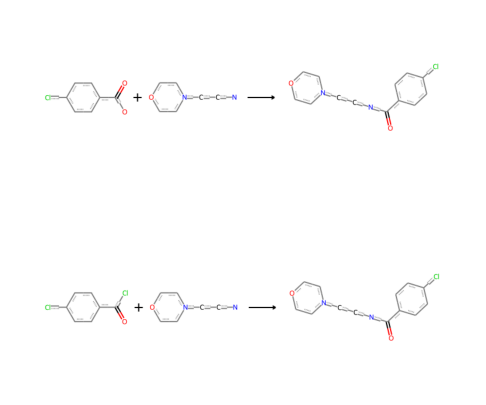

In [4]:
stop = ''
while stop.lower() != 'stop':
    for prod_idx in range(len(list(multiple.items()))):
        nb_rxns = len(list(multiple.items())[prod_idx][1])
        fig, axes = plt.subplots(nb_rxns, 1, figsize=(nb_rxns*5, 5))
        imgs = []
        for rct_idx in range(nb_rxns):
            rxn_smrts = f'{list(multiple.items())[prod_idx][1][rct_idx]}>>{list(multiple.items())[prod_idx][0]}'
            rxn_obj = Reactions.ReactionFromSmarts(rxn_smrts)
            rxn_obj = clear_atom_mapping(rxn_obj)

            # Create a drawer for PNG output
            drawer = rdMolDraw2D.MolDraw2DCairo(800, 300)  # Adjust the size as needed

            # Set drawing options
            opts = drawer.drawOptions()
            opts.addBondIndices = False  # To add bond indices

            # Draw the reaction
            drawer.DrawReaction(rxn_obj)
            drawer.FinishDrawing()

            # Get the PNG data
            png_data = drawer.GetDrawingText()
            print(f'prod_idx: {prod_idx}, rct_idx: {rct_idx}\n')
            print(f'prod_smiles: {list(multiple.items())[prod_idx][0]}\n')
            print(f'rct_smiles: {list(multiple.items())[prod_idx][1][rct_idx]}\n')

            # Display image
            image = Image.open(io.BytesIO(png_data))
            axes[rct_idx].imshow(np.array(image))
            axes[rct_idx].axis('off')

        display(fig)
        stop = input("Press Enter to continue or type 'stop' to stop: ")
        clear_output(wait=True)

        print(f'stop: {stop}\n')
        print(f"stop.lower() == 'stop': {stop.lower() == 'stop'}\n")
    if stop.lower() == 'stop':
        break